WGCNA(Weighted Gene Co-expression Network Analysis)即加权基因共表达网络分析，能帮助我们找到各方面相似的基因模块(module)，探索基因网络与关注表型之间的关系，寻找核心基因。适用于组别较多样本量大的数据，推荐5组(或者15个样品)以上的数据。比如：不同器官或组织类型发育调控、同一组织不同发育调控、非生物胁迫不同时间点应答、病原菌侵染后不同时间点应答。

简单来说WGCNA能帮我们找到和表型相关的一簇基因。通过后续的蛋白互作分析，从众多个基因中挑出我们最关注的基因，可以理解为降维过程。

WGCNA 的一个完整流程，适用于 R 环境下对转录组数据（如 RNA-seq）或微阵列数据进行共表达模块识别和关联分析。 流程涵盖数据预处理、网络构建、模块识别、表型关联及功能富集等分析。

WGCNA 分析构建的是加权的无尺度网络，通过加权的方法对相关性值进行幂次运算，这种处理方式强化了强相关，弱化了弱相关或负相关，使得相关性数值更符合无标度网络特征，更具有生物意义。 具体请查找一些关于 WGCNA 的原理叙述。


# Step 1：安装和加载WGCNA包

In [5]:
# install.packages("BiocManager")
# BiocManager::install("WGCNA")

library(WGCNA)

# 为防止过多线程导致崩溃，建议关闭线程检查
options(stringsAsFactors = FALSE)
allowWGCNAThreads()


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor




Allowing multi-threading with up to 16 threads.


# Step 2: 准备和清洗表达数据

In [12]:
# 表达矩阵 datExpr 的格式：行为基因，列为样本。
# 剔除缺失值和低表达基因。
# 载入表达数据
exprData <- read.csv("expressionList.csv", header=TRUE, row.names=1)
WGCNA0 <- exprData

#log2转换
WGCNA0 <- log2(WGCNA0+1)

# 行列转置
WGCNA0 <- t(WGCNA0)

# 先对基因进行筛选，var计算每个基因方差，筛选基因变化较大的基因，此次选取前50%的基因
# 也可以不筛选基因全部基因去做
vars_res <- apply(WGCNA0, 2, var)

# 计算百分位数截止值
per_res <- quantile(vars_res, probs = seq(0, 1, 0.25)) # quantile生成分位数
per_res

upperGene <- WGCNA0[, which(vars_res > per_res[3])] # 选取方差位于前50%的基因
dim(upperGene) 


0%          25%          50%          75%         100% 
0.000000e+00 3.011791e-05 1.110721e-04 3.648772e-04 1.041685e-01

[1]   12 5379

为什么要做 log2 转换？

RNA-seq 或微阵列数据中的表达值通常是正数，且有些基因表达特别高，会导致分布极度偏斜。
log 转换可以让高表达值被压缩，低表达值被放大，从而更接近正态分布。

目的：使表达数据更平滑、更适合分析；缩小极差，减少偏态；满足后续 WGCNA 网络构建的统计要求。

In [13]:
WGCNA1 <- data.matrix(upperGene)
nGenes <- ncol(WGCNA1)
nSamples <- nrow(WGCNA1)
head(WGCNA1[1:6,1:6])


,Mpz,Pmp22,Hsp90ab1,Ctss,Ifi27,Aqp4
GSM466408,2.274303,2.269427,2.243142,2.218986,2.250876,2.231613
GSM466409,2.295786,2.297237,2.243335,2.220513,2.244112,2.228219
GSM466410,2.288138,2.283658,2.227718,2.210021,2.213204,2.243086
GSM466411,2.254294,2.257156,2.265216,2.233592,2.230124,2.235004
GSM466412,2.285357,2.283044,2.256306,2.225964,2.235184,2.223423
GSM466413,2.273006,2.258740,2.259423,2.232405,2.225998,2.229874


In [14]:
group <- read.csv("group.csv", header=TRUE, row.names=1)
datTraits <- as.factor(group$groups)

library(stringr)
datTraits=as.data.frame(datTraits)
rownames(datTraits) <- colnames(exprData)
colnames(datTraits) <- c("group")
datTraits$sampleRep <- c(rep(1:6,2))
datTraits$groupNo <- c(rep(1,6),rep(2,6))
head(datTraits)


,group,sampleRep,groupNo
,<fct>,<int>,<dbl>
GSM466408,shame,1,1
GSM466409,shame,2,1
GSM466410,shame,3,1
GSM466411,shame,4,1
GSM466412,shame,5,1
GSM466413,shame,6,1


In [15]:
#先检查
gsg <- goodSamplesGenes(WGCNA1, verbose = 3);

gsg[["allOK"]] # 全部合格

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [16]:
# # 如果是False则运行下面这部分
# if (!gsg$allOK){
#   # Optionally, print the gene and sample names that were removed:
#   if (sum(!gsg$goodGenes)>0) 
#     printFlush(paste("Removing genes:", paste(names(WGCNA1)[!gsg$goodGenes], collapse = ", ")));
#     if (sum(!gsg$goodSamples)>0) 
#       printFlush(paste("Removing samples:", paste(rownames(WGCNA1)[!gsg$goodSamples], collapse = ", ")));
#   # Remove the offending genes and samples from the data:
#   WGCNA1 = WGCNA1[gsg$goodSamples, gsg$goodGenes]
# }


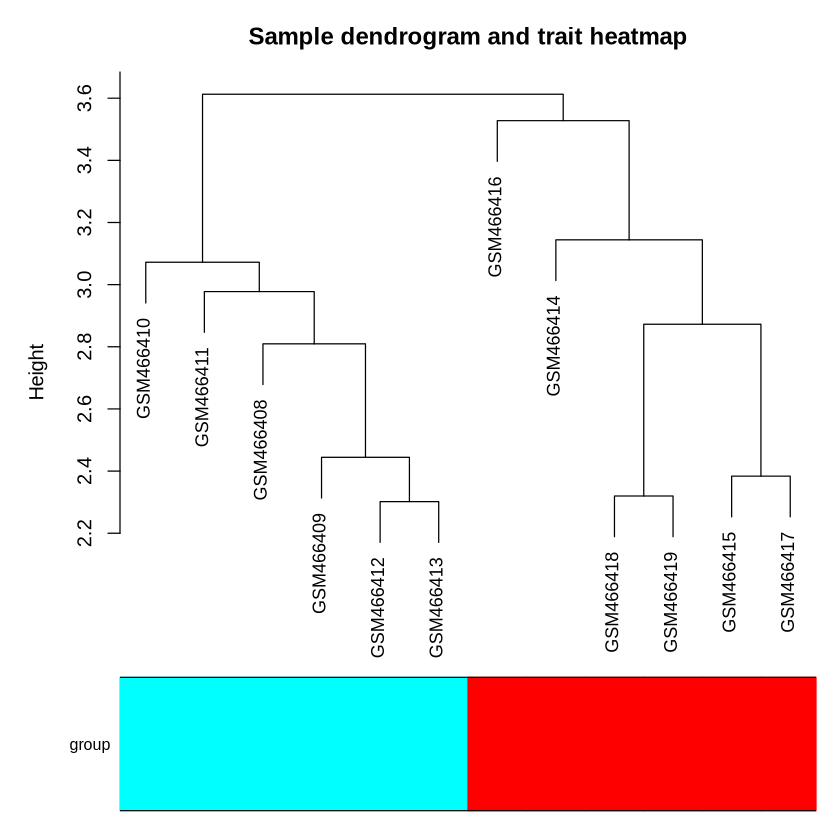

In [17]:
# 使用hclust函数对样本进行层次聚类，dist函数计算基因表达数据间的距离
sampleTree <- hclust(dist(WGCNA1), method = "average")

# 为每个样本的表型信息赋予不同的颜色，并生成颜色向量
traitColors <- numbers2colors(as.numeric(factor(datTraits$group)), 
                                  colors = rainbow(length(table(datTraits$group))), 
                                  signed = FALSE)

# 绘制样本树状图和表型热图，groupLabels参数用于添加表型标签
plotDendroAndColors(sampleTree, 
                    traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap")

样品和分组信息基本对应所以不需要设置cutHeight来进行样本剔除。这个图类似于PCA图查看样本聚类情况。

以上所有都是准备数据阶段出图1张或2张都是关于样本纳入筛选。

# Step3: 最优软阈值

数据准备样本聚类观测结束后，需要寻找最优软阈值（soft thresholding或power），使构建的网络符合无标度拓扑结构。构建共表达网络

In [18]:
# 定义1:30的power值，用于构建不同的基因共表达网络
powers <- c(c(1:10), 
            seq(from = 12, 
                to = 30,
                by = 2))

# 使用pickSoftThreshold函数，计算每个power值对应的scale free topology模型拟合程度和平均连接度，
# 并返回最佳的power值
sft <- pickSoftThreshold(as.matrix(WGCNA1),
                         powerVector = powers, 
                         networkType = "signed")


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.06840  4.780          0.892 2720.00   2730.00 2980.0
2      2  0.09190  2.230          0.916 1550.00   1550.00 1820.0
3      3  0.00478  0.295          0.958  955.00    954.00 1240.0
4      4  0.02970 -0.567          0.969  628.00    622.00  930.0
5      5  0.16500 -1.130          0.968  434.00    425.00  732.0
6      6  0.34200 -1.430          0.977  312.00    301.00  598.0
7      7  0.50000 -1.650          0.978  233.00    220.00  501.0
8      8  0.58200 -1.680          0.973  178.00    165.00  429.0
9      9  0.64900 -1.720          0.980  139.00    126.00  372.0
10    10  0.71100 -1.760          0.982  111.00     98.70  328.0
11    12  0.79300 -1.830          0.985   74.80     62.70  261.0
12    14  0.83800 -1.840          0.985   53.00     41.90  213.0
13    16  0.86600 -1.830          0.983   39.10     29.50  178.0
14    18  0.88000 -1.830          0.978   29.90     21.40  151.0
15    20  0.90400 -1.780 

integer(0)

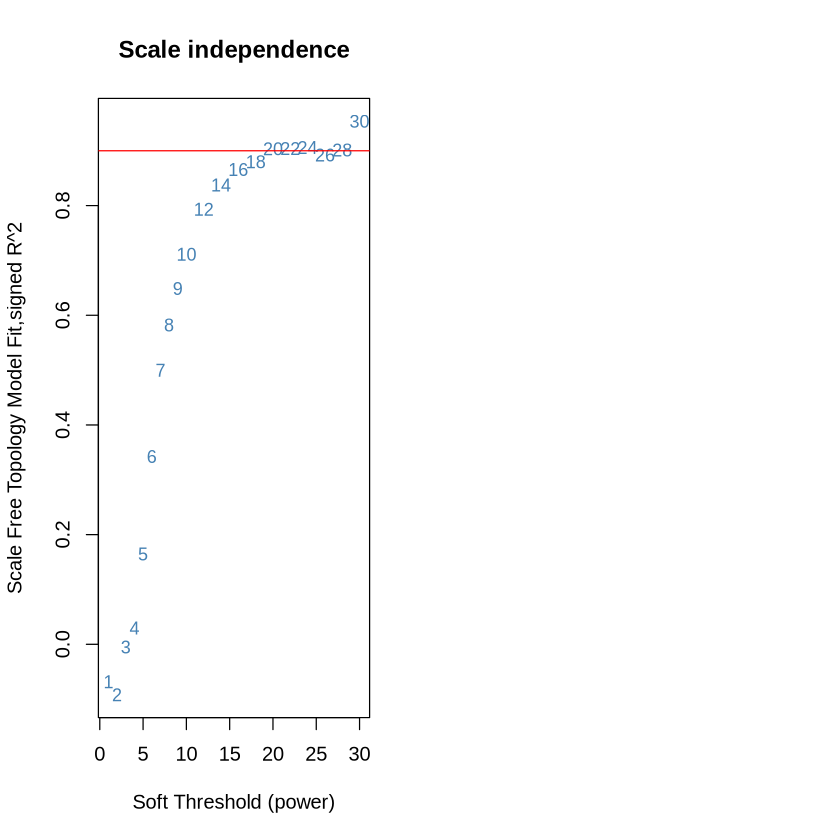

In [19]:
# 根据sft对象中的结果，找到最佳的power值，并将其赋值给变量powerEstimate
powerEstimate = sft$powerEstimate

par(mfrow = c(1,2))  # 将绘图区域分为1行2列
cex1 = 0.9  # 定义文本大小

# 绘制scale independence随power变化的曲线
# 使用text函数添加标签，表示不同的power值
# 使用abline函数添加水平线，表示目标scale independence值（这里设置为0.9）
plot(sft$fitIndices[,1],  # x轴为power值
     -sign(sft$fitIndices[,3])*sft$fitIndices[,2],  # y轴为scale independence指标
     xlab = "Soft Threshold (power)",  # x轴标签
     ylab = "Scale Free Topology Model Fit,signed R^2",  # y轴标签
     type = "n",  # 不绘制点和线
     main = paste("Scale independence")) +  # 图标题
  text(sft$fitIndices[,1],  # 在每个点上添加标签
       -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
       labels = powers, 
       cex = cex1,
       col = "steelblue") +
  abline(h = 0.90,  # 添加水平线
         col = "red")


integer(0)

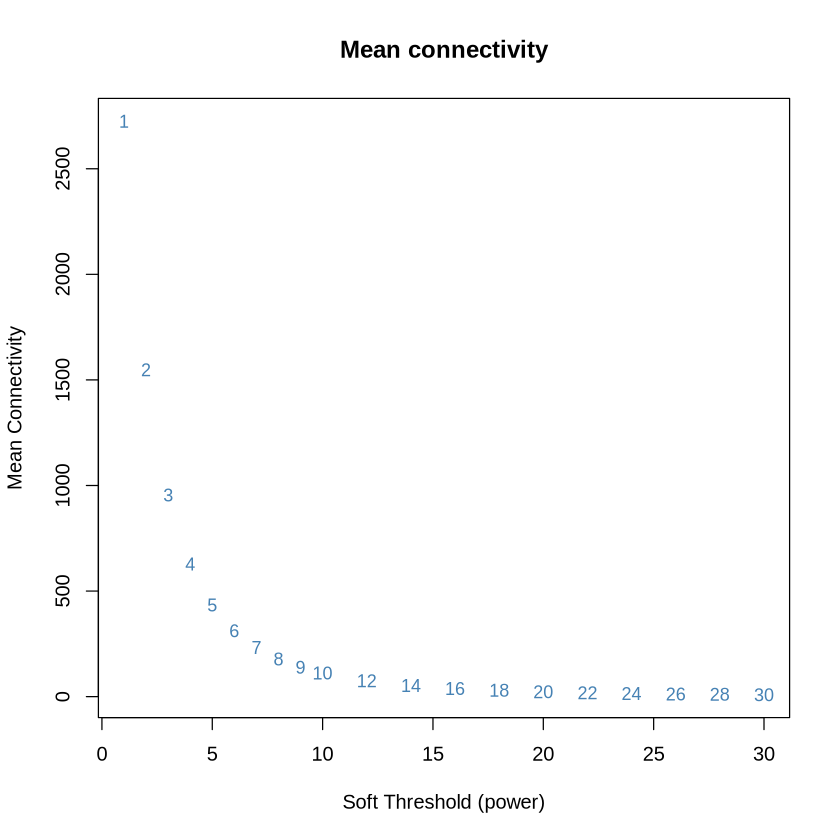

In [20]:
# 绘制mean connectivity随power变化的曲线
# 使用text函数添加标签，表示不同的power值
plot(sft$fitIndices[,1],  # x轴为power值
     sft$fitIndices[,5],  # y轴为mean connectivity指标
     xlab = "Soft Threshold (power)",  # x轴标签
     ylab = "Mean Connectivity",  # y轴标签
     type="n",  # 不绘制点和线
     main = paste("Mean connectivity")) +  # 图标题
  text(sft$fitIndices[,1],  # 在每个点上添加标签
       sft$fitIndices[,5],
       labels = powers, 
       cex = cex1, 
       col = "steelblue")


Scale independence图

绘制power值对应的散点图；结果显示从1开始整个变化趋势都还很明显，而某个值以后趋势已经不明显了；因此选取这数值作为最佳的power值。 Power一般R方要高于0.8。如果调试后还不能满足可能是表达矩阵没有处理恰当，或者不满足分析条件比如样本里太少，基因数目过多等原因

mean connectivity图

该图为不同软阈值情况下的网络连通度，平均连接度和power取值间关系选取power，一般在平均连接度变化呈平稳处

# Step4: 构建共表达网络

基于最优软阈值构建共表达网络，将基因划分到不同模块后，可以绘制基因聚类树：

In [21]:
if(T){ # 使用blockwiseModules函数，将基因共表达网络划分为不同的模块，
       #并将结果存储在net对象中
  net = blockwiseModules(
    as.matrix(WGCNA1),  # 基因表达矩阵
    power = sft$powerEstimate,  # power值
    maxBlockSize = nGenes,  # 最大块大小
    TOMType = "unsigned",  # TOM类型
    minModuleSize = 30,  # 最小模块大小
    reassignThreshold = 0,  # 重分配阈值
    mergeCutHeight = 0.25,  # 合并高度阈值
    numericLabels = TRUE,  # 数字标签
    pamRespectsDendro = FALSE,  # PAM是否考虑树状图结构
    saveTOMs = F,  # 是否保存TOM矩阵
    verbose = 3  # 输出详细信息的级别
  )
  table(net$colors)  # 显示不同模块的基因数目
}

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 16 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 1 because their KME is too low.
     ..removing 1 genes from module 3 because their KME is too low.
     ..removing 1 genes from module 9 because their KME is too low.
     ..removing 1 genes from module 15 because their KME is too low.
     ..removing 1 genes from module 17 because their KME is too low.
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...



  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
216 988 571 394 388 306 288 236 236 235 233 214 162 158 153 149 142 137  92  81 

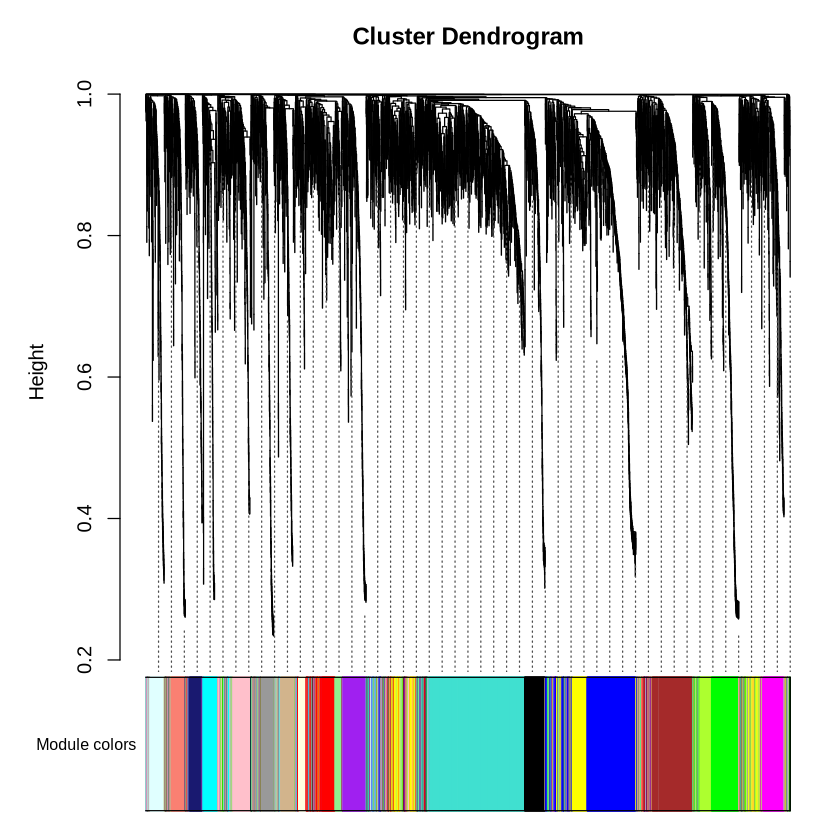

In [22]:
##模块可视化,分类树与色块对应图
if(T){  # 判断条件为真
  # 将模块标签转换为颜色，以便绘图
  moduleColors=labels2colors(net$colors)
  table(moduleColors)  # 显示不同颜色的基因数目

  # 绘制分类树和模块颜色对应图
  plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                      "Module colors",
                      dendroLabels = FALSE, hang = 0.03,
                      addGuide = TRUE, guideHang = 0.05)
}


Cluster Dendrogram

聚类树状图，这个图可以分为两部分看：上半部分是基因的层次聚类树状图，下半部分是基因模块，也就是网络模块。上下对应，可以看到距离较近的基因（聚类到同一条分支）被划分到了同一模块。每个颜色代表一个模块，灰色代表里面基因不属于任何模块。


# Step5: 表型与基因相关性热图

在以上结果基础上，绘制表型与基因相关性热图，这个图片也是WGCNA中最重要的结果

In [30]:
library(WGCNA)  # 载入WGCNA包
library(forcats)  # 载入forcats包
datTraits$group <- factor(datTraits$group)  # 将datTraits$group转换为因子变量
levels(datTraits$group)  # 显示因子变量的水平


[1] "SNI"   "shame"

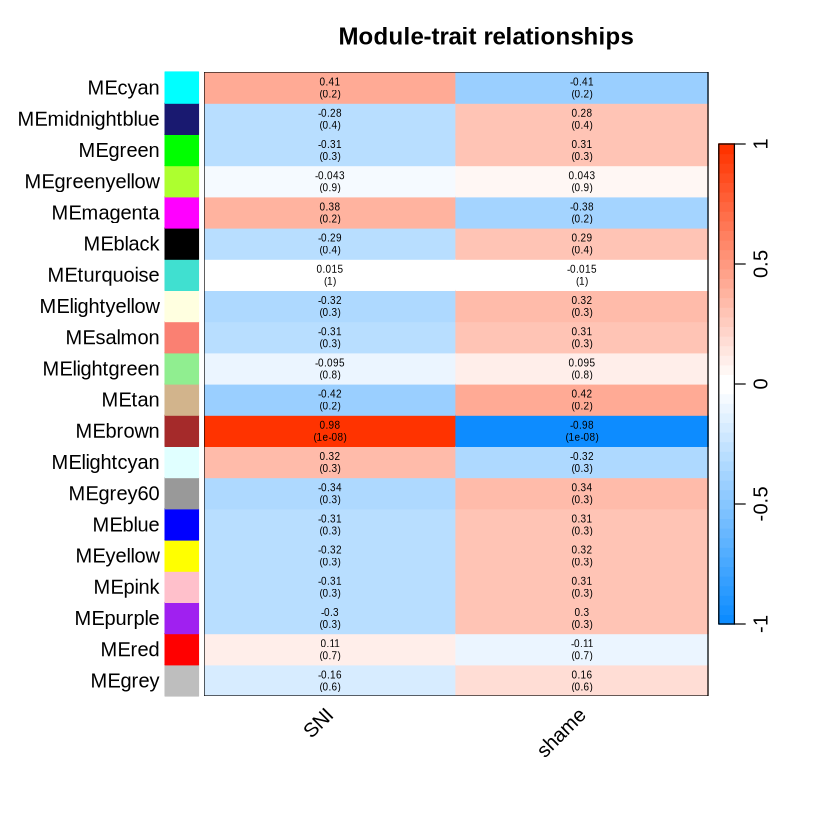

In [31]:
if(T){ 
  nGenes = ncol(WGCNA1)  # 基因数目
  nSamples = nrow(WGCNA1)  # 样本数目
  design <- model.matrix(~0+datTraits$group)  # 构建模型矩阵
  colnames(design)= levels(datTraits$group)  # 修改列名，获取分组信息
  MES0 <- moduleEigengenes(WGCNA1,moduleColors)$eigengenes  # 计算模块特征向量
  MEs = orderMEs(MES0)  # 对模块特征向量排序
  moduleTraitCor <- cor(MEs,design,use = "p")  # 计算模块特征向量与表型的相关系数矩阵
  moduleTraitPvalue <- corPvalueStudent(moduleTraitCor,nSamples)  # 计算相关系数矩阵的p值
  textMatrix = paste(signif(moduleTraitCor,2),"\n(",
                     signif(moduleTraitPvalue,1),")",sep = "")  # 构建绘图时用的文本矩阵
  dim(textMatrix)=dim(moduleTraitCor)  # 修改文本矩阵的维度，与相关系数矩阵相同
  par(mar=c(6, 8.5, 3, 3))  # 设置绘图边距
  labeledHeatmap(Matrix = moduleTraitCor,  # 绘制带标签的热图
                 xLabels = colnames(design),  # x轴标签
                 yLabels = names(MEs),  # y轴标签
                 ySymbols = names(MEs),  # y轴符号
                 colorLabels = FALSE,  # 不显示颜色标签
                 colors = blueWhiteRed(50),  # 颜色范围
                 textMatrix = textMatrix,  # 显示文本矩阵
                 setStdMargins = FALSE,  # 不设置标准边距
                 cex.text = 0.5,  # 文本大小
                 zlim = c(-1,1),  # 颜色映射范围
                 main = paste("Module-trait relationships"))  # 绘图标题
}


Module-trait relationships

上图中，最左侧的颜色块代表模块，最右侧的颜色条代表相关性范围。中间部分的热图中，颜色越深相关性越高，红色表示正相关，蓝色表示负相关；每个单元格中的数字表示相关性和显著性。一般，我们会按相关性的绝对值筛选最相关模块，即负相关模块也应该考虑在内。grey模块中包含了所有未参与聚类的基因，因此是无效模块，不应用于后续分析。

# Step6: 感兴趣性状的模块相关性分析

感兴趣性状的模块与表型之间相关性分析，输出图片为散点图


[1] "brown"


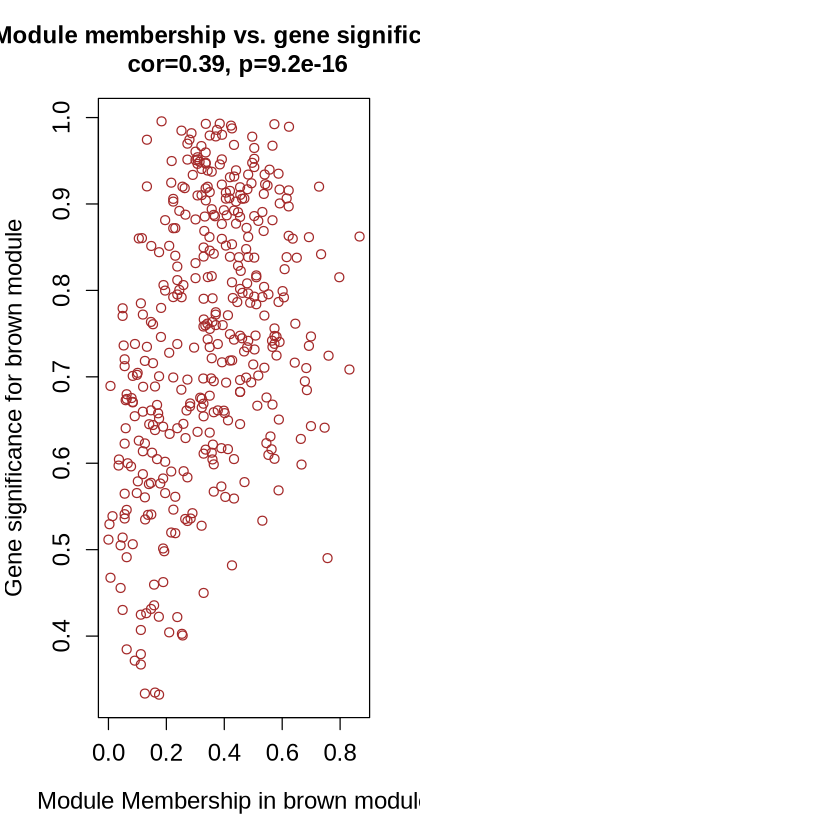

In [32]:
if(T){
  modNames = substring(names(MEs), 3)  # 提取模块名称
  geneModuleMembership = as.data.frame(cor(WGCNA1, MEs,
                                           use = "p",method = "spearman"))  #计算基因与模块的相关系数矩阵
  MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))  # 计算相关系数矩阵的p值
  names(geneModuleMembership) = paste("MM", modNames, sep="")  # 修改列名
  names(MMPvalue) = paste("p.MM", modNames, sep="")  # 修改列名

  geneTraitSignificance <- as.data.frame(cor(WGCNA1,datTraits$groupNo,use = "p"))  # 计算基因与表型的相关系数矩阵
  GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance),nSamples))  # 计算相关系数矩阵的p值
  names(geneTraitSignificance)<- paste("GS.",names(datTraits$group),sep = "")  # 修改列名
  names(GSPvalue)<-paste("GS.",names(datTraits$group),sep = "")  # 修改列名

  selectModule<-c("brown")  # 选择要绘制的模块（这里只选择了一个）
  #selectModule <- modNames  # 批量作图

  par(mfrow=c(ceiling(length(selectModule)/2),2))  # 设置绘图区域，批量作图开始
  for(module in selectModule){
    column <- match(module,selectModule)  # 找到当前模块在geneModuleMembership中的列号
    print(module)  # 输出当前处理的模块名称
    moduleGenes <- moduleColors==module  # 找到属于当前模块的基因

    # 绘制散点图，横轴为基因在当前模块中的模块内连通性，纵轴为基因与表型的相关系数
    verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                       abs(geneTraitSignificance[moduleGenes, 1]),
                       xlab = paste("Module Membership in", module, "module"),
                       ylab = paste("Gene significance for", module, "module"),
                       main = paste("Module membership vs. gene significance\n"),
                       cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
  }
}


针对关键模块和感兴趣的性状进一步挖掘，看看基因与模块的相关性（Module Membership, MM） 和基因与性状的相关性（Gene Significance, GS）之间是否有某种关联。


# Step7: 基因相关性热图

探索所有基因或关注基因之间的相关性，用热图呈现，颜色越深，说明基因之间的相互作用越强。这个图片锦上添花吧，没有表型与基因相关性热图重要。



TOM calculation: adjacency..
..will use 16 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


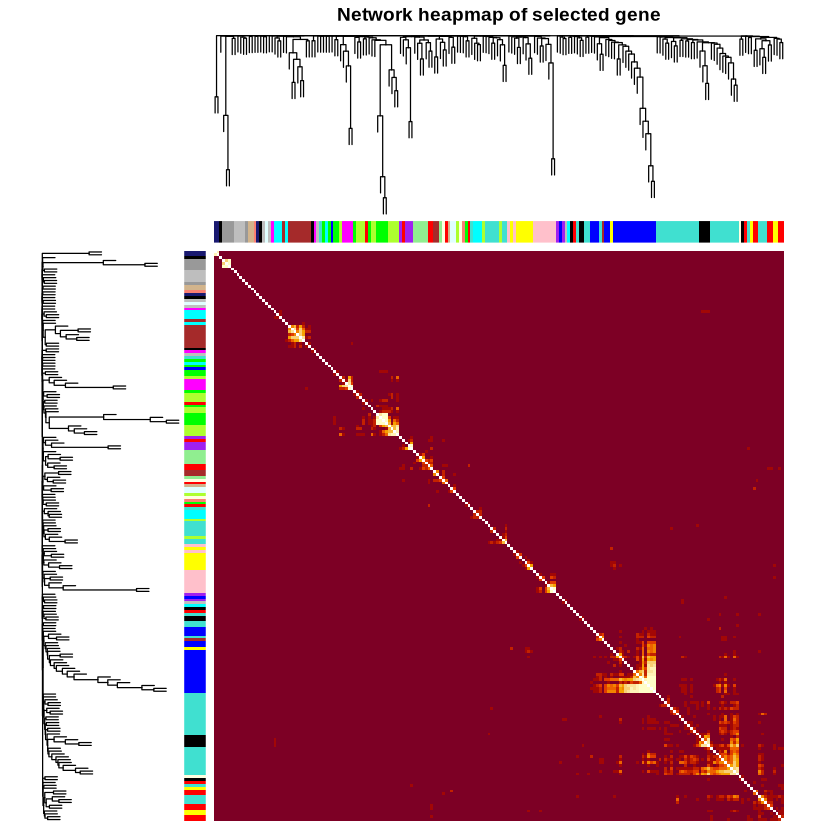

In [ ]:
# 主要是可视化 TOM矩阵，WGCNA的标准配图
# 然后可视化不同 模块 的相关性 热图
# 不同模块的层次聚类图
# 还有模块诊断，主要是 intramodular connectivity

if(T){
  # 提取 WGCNA1 数据的基因树
  geneTree = net$dendrograms[[1]]
  # 计算 TOM 相似度矩阵
  TOM=TOMsimilarityFromExpr(WGCNA1,power=20)
  # 将 TOM 相似度矩阵转换为距离矩阵
  dissTOM=1-TOM
  # 将距离矩阵取7次方，以突出较大的距离差异
  #plotTOM = dissTOM^7
  # 将对角线上的值设为 NA，以避免在可视化时影响效果
  #diag(plotTOM)=NA
  # 绘制 TOM 图
  #pdf("6_allgene_Network-heatmap.pdf",width = 15,height = 15)
  #TOMplot(plotTOM,geneTree,moduleColors,main="Network heapmap plot of all genes")
 
  # 选取 nSelect 个基因进行可视化
  nSelect =200
  set.seed(10)
  select=sample(nGenes,size = nSelect)
  # 提取选定基因的 TOM 相似度矩阵
  selectTOM = dissTOM[select,select]
  # 对选定基因的 TOM 相似度矩阵进行聚类分析，生成基因树
  selectTree = hclust(as.dist(selectTOM),method = "average")
  # 提取选定基因的模块颜色信息
  selectColors = moduleColors[select]
  # 将选定基因的距离矩阵取7次方，以突出较大的距离差异
  plotDiss=selectTOM^7
  # 将对角线上的值设为 NA，以避免在可视化时影响效果
  diag(plotDiss)=NA
  # 绘制选定基因的 TOM 图
  TOMplot(plotDiss,selectTree,selectColors,main="Network heapmap of selected gene")
}


基因之间的相关性热图。其中颜色越深，说明基因之间的相互作用越强。由于对角线表示模块内部基因之间的相互作用，所以自然是对角线上的颜色最深。

# Step8: 模块相关性热图

探索各个模块之间的相关性，这个图片也是锦上添花，没有表型与基因相关性热图重要。

In [ ]:
if(T){ 
  MEs=moduleEigengenes(WGCNA1,moduleColors)$eigengenes  # 计算模块特征向量
  MET = orderMEs(cbind(MEs,datTraits$groupNo))  # 对模块特征向量和表型变量进行排序
  par(cex = 0.9)  # 设置字体大小
  #png("step6-Eigengene-dendrogram.png",width = 800,height = 600)  # 打开png图像文件
  plotEigengeneNetworks(MET, "", marDendro = c(0,4,1,2), marHeatmap = c(3,4,1,2), cex.lab = 0.8, xLabelsAngle
                        = 90,excludeGrey = FALSE)  # 绘制模块特征向量的网络图
}



模块之间的聚类树和相关性热图，探索模块之间的互作关系：

# Step9 提取指定模块的基因做PPI网络分析

In [34]:
#######gene export for VisANT or cytoscape
if(T){  # 判断条件为真
  module="brown"  # 选择要导出的模块
  probes = colnames(WGCNA1)  # 获取基因名称
  inModule = (moduleColors==module)  # 找到属于当前模块的基因
  modProbes=probes[inModule]  # 提取属于当前模块的基因名称
  head(modProbes)  # 显示基因名称前几行
  modTOM = TOM[inModule,inModule]  # 提取属于当前模块的基因之间的TOM值
  dimnames(modTOM)=list(modProbes,modProbes)  # 修改维度名称
  ### 这里只选了top100的基因
  nTop=100  # 设置要选择的基因数目
  IMConn = softConnectivity(WGCNA1[,modProbes])  # 计算当前模块中基因之间的相似性
  top=(rank(-IMConn)<=nTop)  # 找到相似性排名前nTop的基因
  filterTOM=modTOM[top,top]  # 提取相似性排名前nTop的基因之间的TOM值
  # for visANT
  vis = exportNetworkToVisANT(filterTOM,file = paste("visANTinput-",module,".txt",sep = ""),
                              weighted = T,threshold = 0)  # 导出VisANT可用的网络数据
  
  # for cytoscape
  cyt = exportNetworkToCytoscape(filterTOM,
                                 edgeFile = paste("CytoscapeInput-edges-", paste(module, collapse="-"), ".txt", sep=""),
                                 nodeFile = paste("CytoscapeInput-nodes-", paste(module, collapse="-"), ".txt", sep=""),
                                 weighted = TRUE,
                                 threshold = 0.02,
                                 nodeNames = modProbes[top], 
                                 nodeAttr = moduleColors[inModule][top])  # 导出Cytoscape可用的网络数据
}


 softConnectivity: FYI: connecitivty of genes with less than 4 valid samples will be returned as NA.


 ..calculating connectivities.. 


导出文件后需要在cytoscape中进行操作寻找关键基因

---

## 完整的 WGCNA 一般分成以下几个步骤

### 步骤 1：数据准备与清洗

1.1 导入表达数据（如 TPM、FPKM 或 counts，经标准化）

格式要求：行为基因，列为样本。

1.2 缺失值处理

剔除缺失过多的基因/样本。

1.3 基因过滤

去除低表达、低方差的基因，保留变异性高的部分。

1.4 数据转置

转置后行为样本，列为基因（WGCNA 要求此格式）。

### 步骤 2：样本聚类与离群值检测

2.1 使用层次聚类（如 hclust()）

绘制聚类树，查看是否存在异常样本。

2.2 剔除离群样本

手动或自动识别离群样本并剔除。

### 步骤 3：选择软阈值（Soft-thresholding power）

3.1 计算多种 softPower 值下的网络指标

使用 pickSoftThreshold() 函数。

3.2 确定合适的 softPower

满足无标度拓扑标准（scale-free topology）。

### 步骤 4：构建网络并识别模块

4.1 构建加权共表达网络

通常使用 blockwiseModules() 或 adjacency()+TOMsimilarity()。

4.2 模块识别

通过动态剪切树识别模块（颜色表示模块）。

### 步骤 5：模块与性状关联分析

5.1 导入样本的表型数据（traits）

5.2 模块特征基因（module eigengene）与表型相关性分析

使用 cor() 与 corPvalueStudent()。

5.3 可视化模块-性状热图

用 labeledHeatmap() 绘制。

### 步骤 6：挑选关键模块与核心基因（hub genes）

6.1 模块内基因与模块特征基因的相关性（MM）

6.2 基因与性状的相关性（GS）

6.3 筛选高 MM 和高 GS 的核心基因

### 步骤 7：功能富集分析（可选但常用）

7.1 GO、KEGG 富集分析

使用 clusterProfiler、enrichGO()、enrichKEGG() 等。

7.2 富集结果可视化

条形图、气泡图等。

### 步骤 8：网络可视化（可选但重要）

8.1 导出 Cytoscape 文件

使用 exportNetworkToCytoscape() 函数。

8.2 在 Cytoscape 中绘制网络，突出 hub 基因